In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
train_dir = r"C:\Users\dani\Documents\face-emotion-detection\FER-13\train" # Directory containing the training data
test_dir = r"C:\Users\dani\Documents\face-emotion-detection\FER-13\test"  # Directory containing the validation data

In [62]:
train_datagen = ImageDataGenerator(
    shear_range = 0.3,        # Randomly shift the width of images by up to 10%
    zoom_range = 0.3,       # Randomly shift the height of images by up to 10%
    rotation_range = 30,
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2,          # Set aside 20% of the data for validation
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [63]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 32,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",              # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 32,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the validation subset of the data
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [64]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

Modelling

In [80]:
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB1

In [81]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))



c:\Users\dani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [84]:
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='fer2013.keras',
    monitor='val_accuracy',
    save_best_only = True,
    verbose = 1,
    mode='auto'
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='auto'
)

In [74]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [86]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    # callbacks=[early_stopping_cb]
)

Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.5173 - loss: 1.2639 - val_accuracy: 0.5691 - val_loss: 1.1393
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 129s 180ms/step - accuracy: 0.5283 - loss: 1.2314 - val_accuracy: 0.5782 - val_loss: 1.1069
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 132s 184ms/step - accuracy: 0.5326 - loss: 1.2197 - val_accuracy: 0.5873 - val_loss: 1.0919
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 135s 187ms/step - accuracy: 0.5312 - loss: 1.2283 - val_accuracy: 0.5691 - val_loss: 1.1199
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 132s 184ms/step - accuracy: 0.5475 - loss: 1.2010 - val_accuracy: 0.5943 - val_loss: 1.0920
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.5475 - loss: 1.1958 - val_accuracy: 0.5887 - val_loss: 1.1014
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 133s 185ms/step - accuracy: 0.5447 - loss: 1.1903 - val_accuracy: 0.5831 - val_loss: 1.1297
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.5431 -

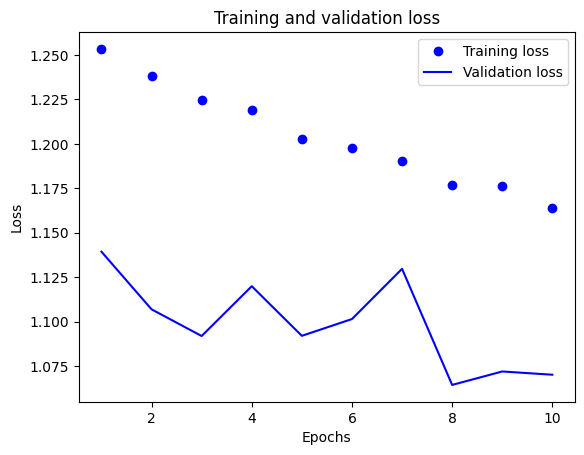

In [87]:
import matplotlib.pyplot as plt
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

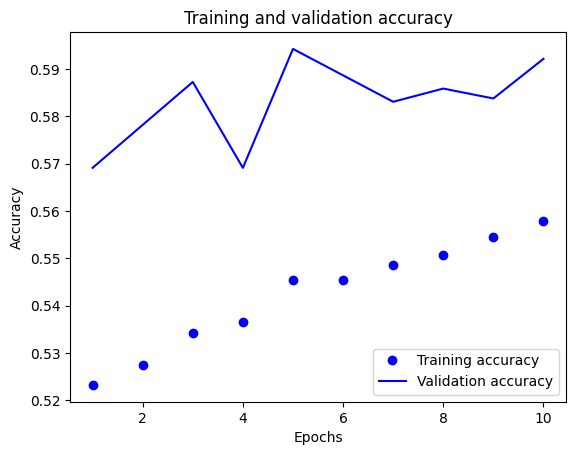

In [88]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


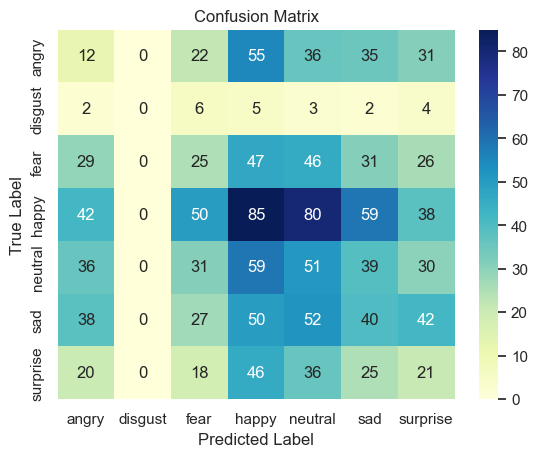

In [89]:
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [90]:
# Evaluate the Model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5913 - loss: 1.0863
Validation Accuracy: 59.22%


In [91]:
model.save('face_emotion.h5')